In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import numpy as np
import numpyro
import jax
import jax.numpy as jnp
from numpyro.infer import MCMC, NUTS, SVI, Trace_ELBO
import nfjax.shtlc as lc
import autograd
import autograd.numpy as anp

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/duke/.local/share/virtualenvs/nfjax-Y-MGz7Lr/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup the model

In [70]:
lmax, nlat, nlon, D = 31, 32, 64, 0.0004
_, L = lc.make_shtdiff(lmax=lmax, nlat=nlat, nlon=nlon, D=D, return_L=True, np=anp)
np.testing.assert_equal(0, L.imag)
L = L.real.astype('f')

def apply_L(L, x, np=jnp):
    X = np.fft.rfft(x, axis=1)
    X = np.hstack(
        (np.einsum('abc,ca->ba', L, X[:,:lmax]),
         np.zeros((X.shape[0], X.shape[1] - lmax), jnp.complex64)
        )
    )
    y = np.real(np.fft.irfft(X, axis=1))
    return y

x0 = jnp.array(np.random.randn(nlat, nlon).astype('f'))
x1 = apply_L(L, x0)

ts = jnp.r_[:100]*0.01
k = 1.0

@jax.jit
def simulate(ts, x0, k):
    dt = ts[1] - ts[0]
    def f(x, t):
        lx = apply_L(L, x, np=jnp)
        x = x + dt * (-x + k * lx)
        return x, x
    _, x_t = jax.lax.scan(f, x0, ts)
    return x_t

xt = simulate(ts, x0, k)

@jax.jit
def loss(x0h):
    xth = simulate(ts, x0h, k)
    sse = jnp.sum(jnp.square(xt - xth))
    return sse

x0h = jnp.ones_like(x0)
print(loss(x0), loss(x0h))

g = jax.jit(jax.grad(loss))
g(x0h);
%timeit simulate(ts, x0, k)
%timeit g(x0h)

0.0 254377.39
2.5 ms ± 2.42 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.82 ms ± 921 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)


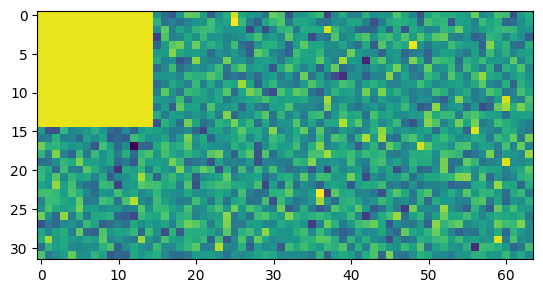

In [71]:
x0 = x0.at[:15,:15].set(3.0)
imshow(x0)

In [72]:
xt = simulate(ts, x0, k)

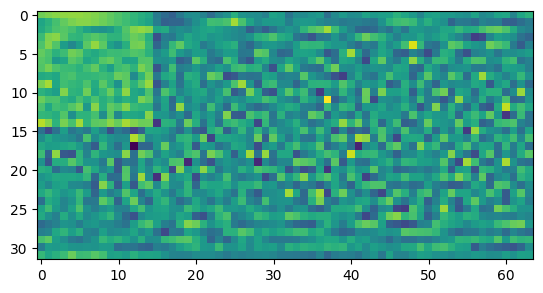

In [73]:
imshow(xt[99])

To use NumPyro we need a target function,

In [74]:
import numpyro.distributions as dist

In [75]:
def logp(xt=None):
    x0h = numpyro.sample('x0h', dist.Normal(jnp.zeros((nlat, nlon)), 1))
    xth_mu = simulate(ts, x0h, k)
    numpyro.sample('xth', dist.Normal(xth_mu, 1), obs=xt)

In [76]:
nuts_kernel = NUTS(logp)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=1000)
rng_key = jax.random.PRNGKey(0)
mcmc.run(rng_key, xt=xt)

sample: 100%|██████████████████████████████████████████| 2000/2000 [07:01<00:00,  4.75it/s, 31 steps of size 1.39e-01. acc. prob=0.83]


In [64]:
samples = mcmc.get_samples()

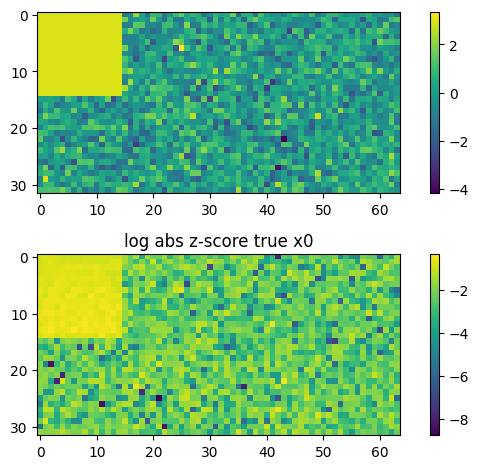

In [66]:
x0h = samples['x0h']
subplot(211); imshow(x0h.mean(axis=0)); colorbar()
subplot(212);
imshow(np.log(np.abs((x0 - x0h.mean(axis=0))/x0h.std(axis=0))))
colorbar(), title('log abs z-score true x0');
tight_layout()